In [19]:
import pandas as pd
import numpy as np
import PIL.Image as Image
import glob
from tqdm import tqdm_notebook
import cv2
import lasio

In [20]:
w6406=lasio.read('./data/6406_3_2 grainsize.las')
print(w6406.keys())
depth = w6406['DEPT']
grain_size = w6406['GRAIN_SIZE']
grain_size

['DEPT', 'GRAIN_SIZE']


array([     nan,      nan,      nan, ...,  3.68451,  4.29296,  4.14085])

In [21]:
w6406 = pd.DataFrame([depth, grain_size])
w6406 = w6406.T
w6406.head(5)
w6406.columns = ['depth', 'gs']




In [22]:
#w6406 = w6406[['DEPT','GRAIN_SIZE']]
w64 = w6406[w6406>0].dropna()

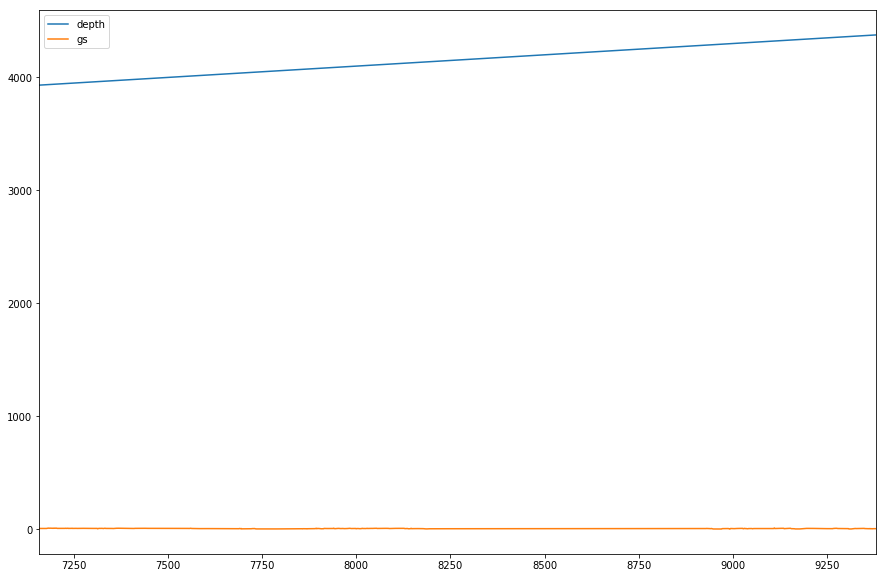

In [23]:
%matplotlib inline
#w64 = w64.set_index('depth')
w64.plot(figsize=(15,10))

In [24]:
imgs = glob.glob('./data/well_6406_3_2_images/*.jpg')
train_df = pd.DataFrame(imgs)
train_df.columns=['imgName']

In [25]:
train_df['img'] = [np.array(cv2.imread("{}".format(idx))) for idx in tqdm_notebook(train_df.imgName)]


A Jupyter Widget

In [26]:
train_df['imgsize'] = train_df['img'].apply(lambda x: x.shape)

In [27]:
print('max dimension', train_df['imgsize'].max())
print('min dimension', train_df['imgsize'].min())



max dimension (2400, 265, 3)
min dimension (1919, 224, 3)


In [28]:
train_df['imgName']

0      ./data/well_6406_3_2_images/6406_3_2_3989_3990...
1      ./data/well_6406_3_2_images/6406_3_2_3994_3995...
2      ./data/well_6406_3_2_images/6406_3_2_3969_3970...
3      ./data/well_6406_3_2_images/6406_3_2_4116_4117...
4      ./data/well_6406_3_2_images/6406_3_2_3974_3975...
5      ./data/well_6406_3_2_images/6406_3_2_4311_4312...
6      ./data/well_6406_3_2_images/6406_3_2_4130_4131...
7      ./data/well_6406_3_2_images/6406_3_2_3952_3953...
8      ./data/well_6406_3_2_images/6406_3_2_4140_4141...
9      ./data/well_6406_3_2_images/6406_3_2_4308_4309...
10     ./data/well_6406_3_2_images/6406_3_2_4308_4308...
11     ./data/well_6406_3_2_images/6406_3_2_4035_4036...
12     ./data/well_6406_3_2_images/6406_3_2_4284_4285...
13     ./data/well_6406_3_2_images/6406_3_2_4045_4046...
14     ./data/well_6406_3_2_images/6406_3_2_3957_3958...
15     ./data/well_6406_3_2_images/6406_3_2_4023_4024...
16     ./data/well_6406_3_2_images/6406_3_2_4053_4054...
17     ./data/well_6406_3_2_ima

In [29]:
train_df['startDepth'] = train_df.imgName.str.replace('.jpg','').str.split('_').str[-2].astype(float)
train_df['endDepth'] = train_df.imgName.str.replace('.jpg','').str.split('_').str[-1].astype(float)
train_df['wellname']= train_df.imgName.str.split('/').str[2]

In [30]:
sd = train_df.startDepth.values
ed = train_df.endDepth.values
gsd = w64.depth.values
gs = w64.gs.values

i,j = np.where((gsd[:,None] >= sd) & (gsd[:,None] <ed))
w64joined= pd.DataFrame(np.column_stack([w64.values[i],train_df.values[j]]), columns=w64.columns.append(train_df.columns))

In [31]:
w64s = w64joined[['gs','depth','imgName','startDepth','endDepth','wellname']]

In [32]:
w64s

,gs,depth,imgName,startDepth,endDepth,wellname
0,5.9662,3931.15,./data/well_6406_3_2_images/6406_3_2_3931_3932...,3931,3932,well_6406_3_2_images
1,5.9662,3931.35,./data/well_6406_3_2_images/6406_3_2_3931_3932...,3931,3932,well_6406_3_2_images
2,5.9662,3931.55,./data/well_6406_3_2_images/6406_3_2_3931_3932...,3931,3932,well_6406_3_2_images
3,5.9662,3931.75,./data/well_6406_3_2_images/6406_3_2_3931_3932...,3931,3932,well_6406_3_2_images
4,5.9662,3931.95,./data/well_6406_3_2_images/6406_3_2_3931_3932...,3931,3932,well_6406_3_2_images
5,5.86479,3932.15,./data/well_6406_3_2_images/6406_3_2_3932_3933...,3932,3933,well_6406_3_2_images
6,5.86479,3932.35,./data/well_6406_3_2_images/6406_3_2_3932_3933...,3932,3933,well_6406_3_2_images
7,5.81408,3932.55,./data/well_6406_3_2_images/6406_3_2_3932_3933...,3932,3933,well_6406_3_2_images
8,5.81408,3932.75,./data/well_6406_3_2_images/6406_3_2_3932_3933...,3932,3933,well_6406_3_2_images
9,5.86479,3932.95,./data/well_6406_3_2_images/6406_3_2_3932_3933...,3932,3933,well_6406_3_2_images


In [33]:
w64s['gs'] = w64s['gs'].astype(float)
w64s['depth']=w64s['depth'].astype(float)
w64s.groupby(w64s.startDepth).aggregate({'gs':'mean','depth':'mean','imgName':'first','startDepth':'first'})

/Users/nathanieljones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nathanieljones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,gs,depth,imgName,startDepth
startDepth,,,,
3931.0,5.966200,3931.550000,./data/well_6406_3_2_images/6406_3_2_3931_3932...,3931.0
3932.0,5.844506,3932.550000,./data/well_6406_3_2_images/6406_3_2_3932_3933...,3932.0
3933.0,5.976338,3933.550000,./data/well_6406_3_2_images/6406_3_2_3933_3934...,3933.0
3935.0,8.460846,3935.550000,./data/well_6406_3_2_images/6406_3_2_3935_3936...,3935.0
3936.0,8.045070,3936.550000,./data/well_6406_3_2_images/6406_3_2_3936_3937...,3936.0
3937.0,7.659718,3937.550000,./data/well_6406_3_2_images/6406_3_2_3937_3938...,3937.0
3938.0,8.187042,3938.550000,./data/well_6406_3_2_images/6406_3_2_3938_3939...,3938.0
3939.0,7.550703,3939.550000,./data/well_6406_3_2_images/6406_3_2_3939_3940...,3939.0
3940.0,6.736900,3940.550000,./data/well_6406_3_2_images/6406_3_2_3940_3941...,3940.0


In [33]:
aggregation_functions = {'gs': 'mean', 'depth': 'mean','imgName':'first', 'img': 'first','endDepth':'first','wellname':'first'}
w64g = w64joined.groupby(w64joined.startDepth).aggregate(aggregation_functions)

DataError: No numeric types to aggregate